## 패키지 불러오기 및 주요 변수 설정하기

In [ ]:
# 한글 폰트(나눔) 설치하기, 런타임 재시작 할 것
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,741 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats, optimize 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 공분산 행렬
cov_mat = pd.DataFrame([[4.501, 3.335, 0.239, 0.413, 2.531, 3.333],
      [3.335, 3.409, 0.262, 0.464, 2.315, 3.429],
      [0.239, 0.262, 0.162, 0.166, -0.145, 0.339],
      [0.413, 0.464, 0.166, 0.232, -0.147, 0.553],
      [2.531, 2.315, -0.145, -0.147, 6.642, 2.732],
      [3.333, 3.429, 0.339, 0.553, 2.732, 4.442]],
      columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산'],
      index=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산'])/100
cov_mat

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
국내주식,0.0450,0.0333,0.0024,0.0041,0.0253,0.0333
해외주식,0.0333,0.0341,0.0026,0.0046,0.0232,0.0343
국내채권,0.0024,0.0026,0.0016,0.0017,-0.0014,0.0034
해외채권,0.0041,0.0046,0.0017,0.0023,-0.0015,0.0055
원자재,0.0253,0.0232,-0.0014,-0.0015,0.0664,0.0273
부동산,0.0333,0.0343,0.0034,0.0055,0.0273,0.0444


In [ ]:
# 비중행렬(각 주식의 기대수익, 최소비중, 최대비중, SAA 비중 포함)
weight_constraint = pd.DataFrame([[8.13, 9.36, 4.33, 3.87, 8.16, 9.01],
                        [5, 5, 5, 5, 5,5],
                        [50, 50, 50, 50, 50,50],
                       [20, 20, 20, 20, 10, 10]],
          columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산'],
          index=['기대수익', '최소비중', '최대비중', '초기 비중'])/100
weight_constraint

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
기대수익,0.0813,0.0936,0.0433,0.0387,0.0816,0.0901
최소비중,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500
최대비중,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000
초기 비중,0.2000,0.2000,0.2000,0.2000,0.1000,0.1000


In [ ]:
# 무위험이자율, 기대수익률, 공분산행렬, 목표적자확률, 목표기대수익률을 설정(전역변수로 선언)
global risk_free_rate, expected_return, covariance_matrix, target_expected_return
risk_free_rate = 0.0348
expected_return = weight_constraint.loc['기대수익', :]
covariance_matrix = cov_mat.copy()
target_expected_return = 6.5/100

In [ ]:
# 다양한 정보들을 확인할 수 있도록 열을 추가해주는 함수를 미리 작성
def add_columns(df):
  global risk_free_rate, expected_return, covariance_return
  return_df, temp = df.copy(), df.copy()
  return_df['비중합'] = temp.apply(lambda x: sum(x), axis=1)
  return_df['기대수익'] = temp @ expected_return
  return_df['실효기대수익'] = return_df['기대수익'] - risk_free_rate
  return_df['표준편차'] = temp.apply(lambda x: calculate_portfolio_std(x, covariance_matrix), axis=1)
  return_df['샤프비율'] = return_df['실효기대수익'] / return_df['표준편차']
  return return_df

## 임의의 포트폴리오 생성

In [ ]:
# 포트폴리오의 기대수익률 계산
def cacluate_expected_portfolio_return(weight, expected_return):
  expected_portfolio_return = sum(np.array(weight) * np.array(expected_return))
  return expected_portfolio_return

# 포트폴리오의 표준편차 계산
def calculate_portfolio_std(weight, cov):
  portfolio_std = (np.array(weight)@ np.array(cov)@ np.array(weight)) ** 0.5
  return portfolio_std

# 샤프비율 계산
def calculate_sharpe_ratio(expected_return, risk_free_rate, std):
  return (expected_return - risk_free_rate) / std

In [ ]:
# 최소비중, 최대비중과 조건을 만족하는 50000개의 포트폴리오를 생성
import random
N = 50000
weights_ls = []
assets = weight_constraint.columns
while len(weights_ls) < N:
  temp_weight = [0 for _ in range(len(assets))]
  for i in range(len(assets)-1):
    temp_weight[i] = random.uniform(weight_constraint.loc['최소비중', assets[i]],
                                    weight_constraint.loc['최대비중', assets[i]])
  temp_weight[-1] = 1- sum(temp_weight)
  if weight_constraint.loc['최소비중', assets[-1]]<= temp_weight[-1] <= weight_constraint.loc['최대비중', assets[-1]]:
    weights_ls.append(temp_weight)

In [ ]:
random_weights_df = pd.DataFrame(weights_ls, columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산'])
random_weights_df = add_columns(random_weights_df)
random_weights_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.2516,0.3070,0.0750,0.0537,0.1070,0.2058,1.0000,0.0818,0.0470,0.1625,0.2891
1,0.1089,0.1802,0.3246,0.0508,0.1268,0.2087,1.0000,0.0709,0.0361,0.1205,0.2995
2,0.0891,0.1554,0.0719,0.0544,0.2053,0.4239,1.0000,0.0820,0.0472,0.1664,0.2833
3,0.1702,0.1457,0.1356,0.3214,0.1714,0.0557,1.0000,0.0648,0.0300,0.1079,0.2779
4,0.1868,0.1118,0.1793,0.3077,0.1264,0.0880,1.0000,0.0636,0.0288,0.1037,0.2773
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.1826,0.1135,0.3069,0.1375,0.1387,0.1208,1.0000,0.0663,0.0315,0.1095,0.2876
49996,0.3531,0.2505,0.1615,0.0958,0.0548,0.0842,1.0000,0.0749,0.0401,0.1439,0.2788
49997,0.1986,0.0711,0.2224,0.0952,0.1039,0.3087,1.0000,0.0724,0.0376,0.1340,0.2807
49998,0.0859,0.0637,0.1568,0.0778,0.1790,0.4368,1.0000,0.0767,0.0419,0.1499,0.2797


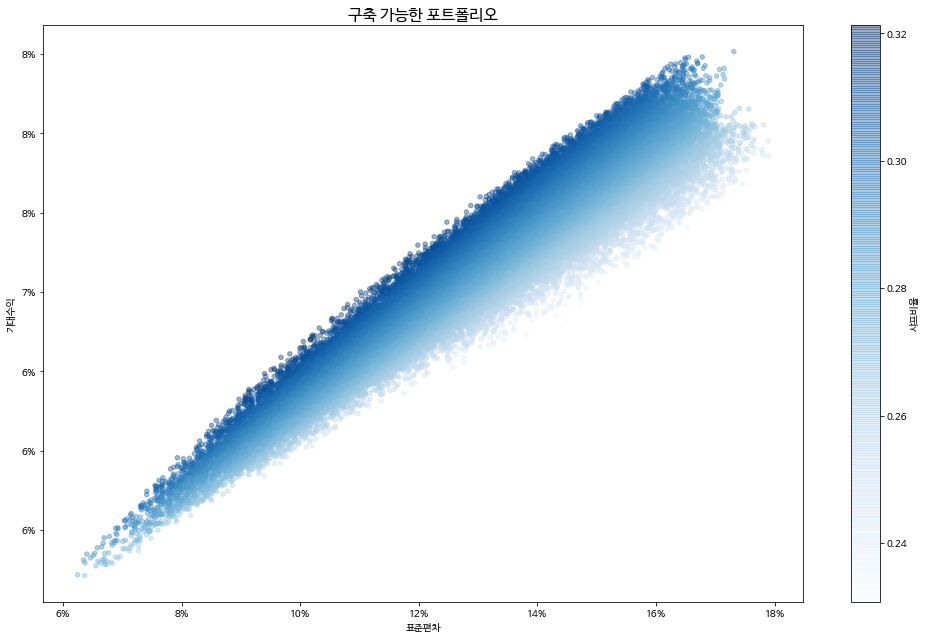

In [ ]:
fig, ax = plt.subplots()
random_weights_df.plot.scatter(x='표준편차', y='기대수익', c=10, ax=ax, cmap='Blues',alpha=0.4, figsize=(14, 9), colorbar=True)
ax.set_title('구축 가능한 포트폴리오', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig.tight_layout()

## MVO(샤프비율 최대화)

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

In [ ]:
# 비중합이 1이라는 제약 조건
MVO_constraint = [{'type':'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
# 샤프비율을 최대화 하는 포트폴리오
max_sharpe_portfolio = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=MVO_constraint, options=options).x
max_sharpe_portfolio_df = pd.DataFrame(max_sharpe_portfolio).T
max_sharpe_portfolio_df.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']

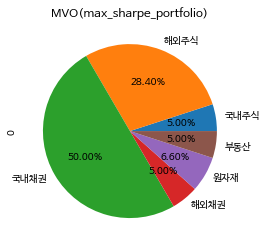

In [ ]:
max_sharpe_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='MVO(max_sharpe_portfolio)',
                                        autopct='%.2f%%')

In [ ]:
# 기대수익은 6.41%, 표준편차는 9.04%, 샤프비율이 32.45%
max_sharpe_portfolio_df = add_columns(max_sharpe_portfolio_df)
max_sharpe_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.0500,0.2840,0.5000,0.0500,0.0660,0.0500,1.0000,0.0641,0.0293,0.0904,0.3245


## 리스크 패리티

In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 패리티의 목적함수
# 만약 의도한 대로 위험기여도가 모두 같다면 목적함수의 값은 0이 된다.
def risk_parity_for_optimization(weight):
  global covariance_matrix
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - 1/len(risk_contribution))
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정(비중 상하한선에 내에서 나오지 않으면 최적화는 실패)
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건은 오직 자산의 비중 합이 1이라는 것 하나 뿐
def weight_sum_optimization(weights):
  return sum(weights)-1

In [ ]:
# 위와 마찬가지로 비중합이 1
RP_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 50000}

In [ ]:
risk_parity_portfolio = optimize.minimize(risk_parity_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RP_constraint, options=options).x
risk_parity_portfolio_df = pd.DataFrame(risk_parity_portfolio).T
risk_parity_portfolio_df.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']
risk_parity_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.0616,0.0646,0.4261,0.3129,0.0783,0.0565


국내주식   0.1667
해외주식   0.1667
국내채권   0.1667
해외채권   0.1667
원자재    0.1667
부동산    0.1667
dtype: float64

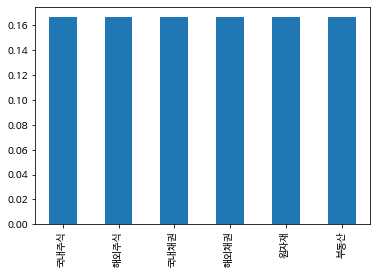

In [ ]:
# 각 자산이 위험 기여도가 1/n으로 동일
risk_contribution_check = calculate_risk_contribution(risk_parity_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')

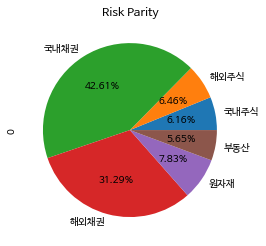

In [ ]:
risk_parity_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Parity',
                                       autopct='%.2f%%')

In [ ]:
risk_parity_portfolio_df = add_columns(risk_parity_portfolio_df)
risk_parity_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.0616,0.0646,0.4261,0.3129,0.0783,0.0565,1.0000,0.0531,0.0183,0.0640,0.2857


## 리스크 버젯팅

In [ ]:
global target_budget
target_budget = np.array([25, 25, 5, 5, 20, 20])/100
print("할당된 budget의 합이 1이 아닙니다") if sum(target_budget) != 1 else print("budget 설정 완료")
display(pd.DataFrame([target_budget], columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']))

budget 설정 완료


,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.2500,0.2500,0.0500,0.0500,0.2000,0.2000


In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 버젯팅의 목적함수
# 만약 의도한 대로 위험기여도가 배분된다면 목적함수의 값은 0이 된다.
def risk_budgeting_for_optimization(weight):
  global covariance_matrix, target_budget
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - target_budget[i])
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정(비중 상하한선에 내에서 나오지 않으면 최적화는 실패)
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건은 오직 자산의 비중 합이 1이라는 것 하나 뿐
def weight_sum_optimization(weights):
  return sum(weights)-1

In [ ]:
# 위와 마찬가지로 비중합이 1
RB_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
risk_budgeting_portfolio = optimize.minimize(risk_budgeting_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RB_constraint, options=options).x
risk_budgeting_portfolio_df = pd.DataFrame(risk_budgeting_portfolio).T
risk_budgeting_portfolio_df.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']
risk_budgeting_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.1340,0.1451,0.2998,0.1965,0.1203,0.1042


국내주식   0.2500
해외주식   0.2500
국내채권   0.0500
해외채권   0.0500
원자재    0.2000
부동산    0.2000
dtype: float64

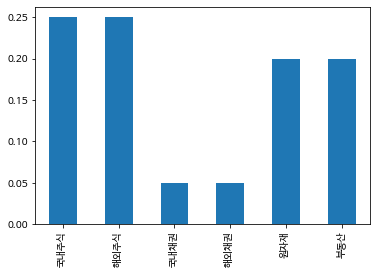

In [ ]:
# 각 자산이 위험 기여도가 목표로 했던 것과 동일
risk_contribution_check = calculate_risk_contribution(risk_budgeting_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')

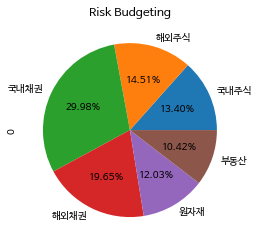

In [ ]:
risk_budgeting_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Budgeting',
                                       autopct='%.2f%%')

In [ ]:
risk_budgeting_portfolio_df = add_columns(risk_budgeting_portfolio_df)
risk_budgeting_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.1340,0.1451,0.2998,0.1965,0.1203,0.1042,1.0000,0.0643,0.0295,0.1007,0.2927


## 벤치마크(동일가중 포트폴리오, 글로벌 최소분산 포트폴리오)

### 동일가중 포트폴리오

In [ ]:
# 동일한 비중으로 설정
equal_weight_portfolio = pd.DataFrame([1/len(cov_mat)] * len(cov_mat)).T
equal_weight_portfolio.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']
equal_weight_portfolio

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.1667,0.1667,0.1667,0.1667,0.1667,0.1667


In [ ]:
equal_weight_portfolio = add_columns(equal_weight_portfolio)
equal_weight_portfolio

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.1667,0.1667,0.1667,0.1667,0.1667,0.1667,1.0000,0.0714,0.0366,0.1280,0.2861


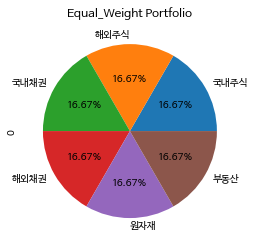

In [ ]:
equal_weight_portfolio.iloc[0,:6].plot(kind='pie',
                                title='Equal_Weight Portfolio',
                                autopct='%.2f%%')

### 최소분산 포트폴리오

In [ ]:
# 분산이 최소가 되도록 최적화
def GMV_for_optimization(weight):
  global covariance_matrix
  variance = np.array(weight).T @ covariance_matrix @ np.array(weight)
  return variance

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

In [ ]:
# 비중합이 1인 제약조건
GMV_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
GMV_portfolio = optimize.minimize(GMV_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=GMV_constraint, options=options).x
GMV_portfolio_df = pd.DataFrame(GMV_portfolio).T
GMV_portfolio_df.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']
GMV_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.0500,0.0500,0.5000,0.3000,0.0500,0.0500


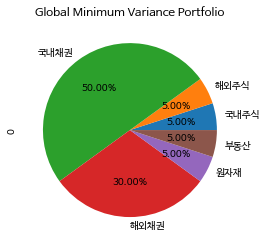

In [ ]:
GMV_portfolio_df.iloc[0,:6].plot(kind='pie',
                                title='Global Minimum Variance Portfolio',
                                autopct='%.2f%%')

In [ ]:
GMV_portfolio_df = add_columns(GMV_portfolio_df)
GMV_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율
0,0.0500,0.0500,0.5000,0.3000,0.0500,0.0500,1.0000,0.0506,0.0158,0.0566,0.2790


## 효율적 투자곡선과 함께 표시

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 기대수익률을 계산하는 함수(0을 기준으로 등호가 쓰이므로 목표기대수익률을 뺀다)
def expected_return_for_optimization(weight):
  global expected_return, target_expected_return
  expected_portfolio_return = sum(np.array(weight) * np.array(expected_return))
  return expected_portfolio_return - target_expected_return

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

# 효율적 투자곡선을 그리기 위한 제약 조건
EF_constraints = [{'type':'eq', 'fun': weight_sum_optimization},
                {'type': 'eq', 'fun': expected_return_for_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

# 주어진 기대수익률 하에서 분산이 최소(샤프비율이 최대)가 되는 포트폴리오들을 찾아냄
efficient_frontier = []
for num in range(400, 852, 2):
  target_expected_return = num/10000
  result = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=EF_constraints)['x']
  efficient_frontier.append(result)

In [ ]:
efficient_frontier = pd.DataFrame(efficient_frontier, columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산'],
                                  index=np.arange(0.0400, 0.0852, 0.0002))
efficient_frontier = add_columns(efficient_frontier)
efficient_frontier = efficient_frontier.set_index('표준편차')

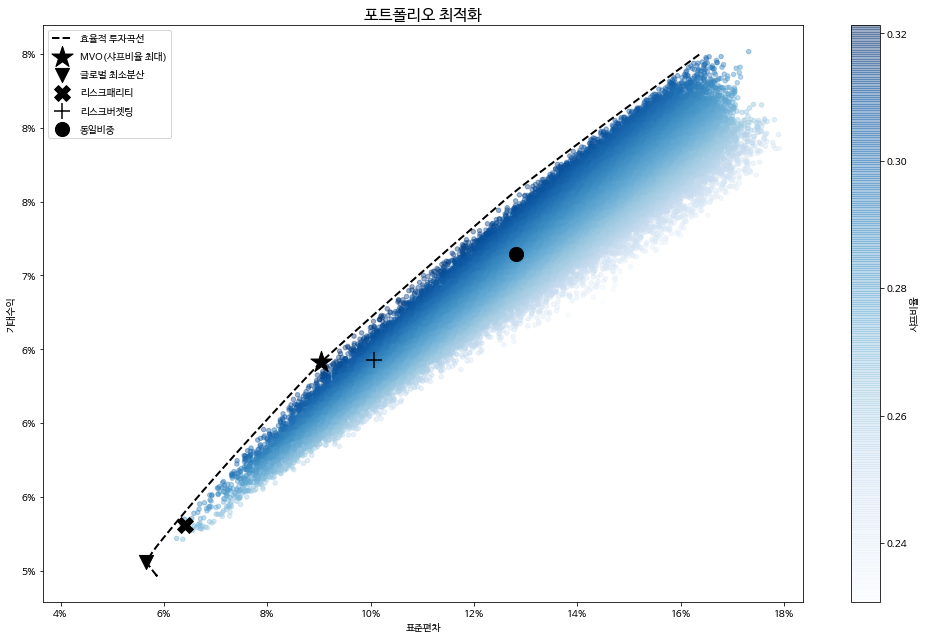

In [ ]:
fig, ax = plt.subplots()
random_weights_df.plot.scatter(x='표준편차', y='기대수익', c=10, ax=ax, cmap='Blues',alpha=0.4, figsize=(14, 9), colorbar=True)

efficient_frontier['기대수익'].plot(linestyle='--', lw=2, ax=ax, c='k', label='효율적 투자곡선')

r, sd = max_sharpe_portfolio_df['기대수익'], max_sharpe_portfolio_df['표준편차']
ax.scatter(sd, r, marker='*', color='k', s=500, label='MVO(샤프비율 최대)')

r, sd = GMV_portfolio_df['기대수익'], GMV_portfolio_df['표준편차']
ax.scatter(sd, r, marker='v', color='k', s=200, label='글로벌 최소분산')

r, sd = risk_parity_portfolio_df['기대수익'], risk_parity_portfolio_df['표준편차']
ax.scatter(sd, r, marker='X', color='k', s=250, label='리스크패리티')

r, sd = risk_budgeting_portfolio_df['기대수익'], risk_budgeting_portfolio_df['표준편차']
ax.scatter(sd, r, marker='+', color='k', s=250, label='리스크버젯팅')

r, sd = equal_weight_portfolio['기대수익'], equal_weight_portfolio['표준편차']
ax.scatter(sd, r, marker='o', color='k', s=200, label='동일비중')


ax.legend(labelspacing=0.8)
ax.set_xlim(min(efficient_frontier.index)-0.02, max(efficient_frontier.index)+.02)
ax.set_title('포트폴리오 최적화', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig.tight_layout()

## 추가적인 제약 조건

### MVO에 제약 조건 추가

Shortfall risk 제약 조건 추가  
** Shortfall Risk: 설정한 용인 가능 최소 수익률 이하로 수익률이 떨어질 확률

In [ ]:
# 무위험이자율, 기대수익률, 공분산행렬, 목표적자확률, 목표기대수익률을 전역변수로 선언
risk_free_rate = 0.0348
minimum_return = -0.05
expected_return = weight_constraint.loc['기대수익', :]
covariance_matrix = cov_mat.copy()
target_shortfall_prob  = 5/100

# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])


# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 적자확률 계산하는 함수
def calculate_portfolio_shortfall_prob(minimum_return, std, expected_return):
  rv = stats.norm()
  shortfall_prob = rv.cdf((minimum_return-expected_return)/std)
  return shortfall_prob
# 적자확률 제약 조건 계산(target 값보다 작게 나와야 함)
def short_fall_prob_for_optimization(weight):
  global expected_return, minimum_return, covariance_matrix, taret_shortfall_prob
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  short_fall_prob = calculate_portfolio_shortfall_prob(minimum_return, portfolio_std, expected_portfolio_return)
  return target_shortfall_prob - short_fall_prob

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

# 제약 조건 설정(short_fall_risk 추가)
options = {'ftol': 1e-20, 'maxiter': 5000}
extra_constraint = [{'type':'eq', 'fun': weight_sum_optimization},
                {'type': 'ineq', 'fun': short_fall_prob_for_optimization}]

In [ ]:
max_sharpe_portfolio_2_df = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=extra_constraint, options=options).x
max_sharpe_portfolio_2_df = pd.DataFrame(max_sharpe_portfolio_2_df).T
max_sharpe_portfolio_2_df.columns = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']
max_sharpe_portfolio_2_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.0500,0.0818,0.5000,0.2409,0.0774,0.0500


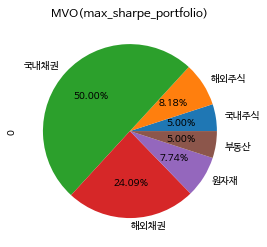

In [ ]:
max_sharpe_portfolio_2_df.iloc[0,:6].plot(kind='pie',
                                       title='MVO(max_sharpe_portfolio)',
                                        autopct='%.2f%%')